In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from utils.fmri_signal_extract import signal_extract


from nilearn import plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

from neuroHarmonize import harmonizationLearn #
from neuroCombat import neuroCombat
from neurocombat_sklearn import CombatModel


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/datasets/struct.py:378: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  warnings.warn("Default resolution of the MNI template will change "


  1 region(s) detected from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_ADNI3/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_ADNI3/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_ADNI3/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_ADNI3/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_ADNI3/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Im

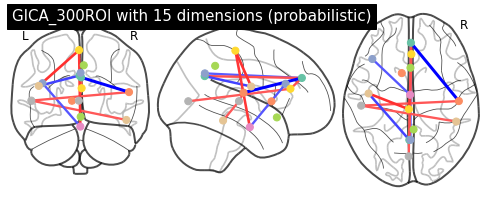

In [2]:
masker_GICA_300ROI = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_ADNI3/nets_CN_ADNI3.nii'

subjects_ts = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii',
               '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_6264_v164_.nii',
               '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_6833_v164_.nii',
               '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_006_S_6252_v164_.nii']

# ts shape (n_subjects), and in each subject shape (vols, rois)
ts, roi_img, labels, masker_type = signal_extract(subjects_ts, masker_GICA_300ROI, masker_type='Maps')

connectome_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices = connectome_measure.fit_transform(ts)
mean_correlation_matrix = connectome_measure.mean_
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=masker_GICA_300ROI)

plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="90%",
                         title='GICA_300ROI with {} dimensions (probabilistic)'.format(15))
plotting.show()

In [3]:
# covars = {'SITE':[1,2],
#           'SEX_M':[0, 1],
#           'SEX_F':[1,0],
#           'AGE':[80,85]}
covars = {'SITE':[1,2,1,2],
          'SEX':[2, 1,1,2],
          'AGE':[80,85, 80,78]}
categorical_cols = ['SEX']
batch_col = ['SITE']
df_covars = pd.DataFrame(covars)
df_covars.head()

,SITE,SEX,AGE
0,1,2,80
1,2,1,85
2,1,1,80
3,2,2,78


In [24]:
def corr_matrix_harmonization(corr, cov, smooth_terms: list = [], v: bool = 0):
    """
    Harmonization with ComBat over correlation matrix and their covariables.
    ComBat used: https://github.com/rpomponio/neuroHarmonize

    :param corr: Correlation matrix this can be 2D (rows, columns) or 3D (subjects, rows, columns)
    :param cov: pandas.DataFrame with the covariables. All covariates must be encoded numerically
     (you must handle categorical covariates in a pre-processing step, see pandas.get_dummies).
     The DataFrame must also contain a single column called "SITE" with labels that identify
     sites (the labels in "SITE" need not be numeric)
    :param smooth_terms: specifying nonlinear co variate effects, it's a list with the terms.
    For example, you may want to specify age as a nonlinear term in the harmonization model,
     if age exhibits nonlinear relationships with brain volumes or any variable smooth_terms=['AGE'].
    :param v: bool, version to use in the correlation matrix harmonization.
    {0: takes the full matrix, 1: takes only the triangular and the other values are set to 0}
    :return: Harmonized Correlation Matrix, the same dimension as the input
    """
    subj_corr = np.empty((0, 0), float)
    m_flat_row = np.zeros((0, corr.shape[1]*corr.shape[1]))
    for i in range(len(corr)):
        if v:
            # Only select a triangular matrix and the other values is 0
            #matriz_triu = np.triu(corr, k=0)
            matriz_tril = np.tril(corr[i], k=0)
            matriz_diag = np.diag(np.diag(corr[i]))
            matriz_dim = corr[i].shape[0]
            m_flat_column = matriz_tril.flatten()
            m_flat_row = np.vstack((m_flat_row, m_flat_column.reshape(1, -1)))
        else:
            # Full matrix
            matriz_column = corr[i].flatten()
            matriz_dim = corr[i].shape[0]
            matriz_row = matriz_column.reshape(1, -1)
            m_flat_row = np.vstack((m_flat_row, matriz_row))
    if corr.shape[1] <= 10:
        # ComBat don't use Empirical Bayes when the harmonization is made with a small number of features
        if smooth_terms:
            my_model, my_data_adj = harmonizationLearn(m_flat_row, cov, smooth_terms, eb=False)
        else:
            my_model, my_data_adj = harmonizationLearn(m_flat_row, cov, eb=False)
    else:
        # ComBat uses Empirical Bayes to fit a prior distribution for the site effects for each site
        if smooth_terms:
            my_model, my_data_adj = harmonizationLearn(m_flat_row, cov, smooth_terms)
        else:
            my_model, my_data_adj = harmonizationLearn(m_flat_row, cov)
    if v:
        matriz_orig = m_flat_row.reshape(matriz_dim, matriz_dim)
        matriz_orig = matriz_orig + matriz_orig.T - matriz_diag
    else:
        matriz_orig = my_data_adj.reshape(corr.shape[0] , corr.shape[1], corr.shape[2])

    return my_model, matriz_orig

In [5]:
a = corr_matrix_harmonization(corr=correlation_matrices, cov=df_covars, v=0)
a[3]

/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/neuroHarmonize/neuroCombat.py:235: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


array([[ 1.00000000e+00,  3.82130422e-01, -2.44207018e-02,
        -6.05126635e-02, -1.88101839e-01, -4.29564235e-02,
        -1.45872920e-01,  5.25627924e-02,  2.44217173e-01,
         1.25252902e-02, -9.59813859e-02, -2.42876694e-01,
        -1.41522753e-01,  6.40191361e-02, -2.20349990e-01],
       [ 3.82130422e-01,  1.00000000e+00, -3.45012757e-01,
        -1.62806488e-01, -3.47813114e-01,  2.48478698e-01,
        -3.02580902e-01,  6.15529684e-02, -1.22004695e-01,
         1.72831182e-01, -1.37144441e-01, -2.24216059e-01,
         1.49992100e-01,  7.28882445e-02, -2.29431242e-01],
       [-2.44207018e-02, -3.45012757e-01,  1.00000000e+00,
         5.59502808e-02, -1.37961842e-02, -1.77137323e-02,
        -3.52876527e-03,  1.78875934e-01,  1.30590138e-01,
         1.89255817e-02, -1.52826556e-01, -1.30291539e-02,
        -2.05807749e-01,  1.93234809e-01,  1.88408208e-01],
       [-6.05126635e-02, -1.62806488e-01,  5.59502808e-02,
         1.00000000e+00, -8.43378490e-02, -1.03922421

In [6]:
correlation_matrices[3]

array([[ 1.        ,  0.3717334 ,  0.05415941, -0.06934927, -0.3246075 ,
        -0.08787027, -0.05048806,  0.12648582,  0.27341726, -0.00690071,
        -0.00667239, -0.27551696, -0.11126018,  0.12098327, -0.12203573],
       [ 0.3717334 ,  1.        , -0.16158576, -0.23917016, -0.3649338 ,
         0.36168584, -0.15454271,  0.13900092, -0.05916722,  0.16252995,
        -0.17869805, -0.27182913,  0.14441971,  0.16308221, -0.23183338],
       [ 0.05415941, -0.16158576,  1.        ,  0.21406147, -0.14311005,
         0.00617733, -0.24862844,  0.33377847,  0.1556228 ,  0.2207977 ,
        -0.19018666, -0.1527358 , -0.17130549,  0.11283075,  0.25453418],
       [-0.06934927, -0.23917016,  0.21406147,  1.        ,  0.02443224,
        -0.10503753, -0.02293977,  0.23447475, -0.0628723 , -0.11591806,
         0.33299032,  0.3737861 ,  0.06797651,  0.2581345 ,  0.29390916],
       [-0.3246075 , -0.3649338 , -0.14311005,  0.02443224,  1.        ,
        -0.23546343,  0.18577598, -0.21719715, 

In [7]:
# https://github.com/rpomponio/neuroHarmonize
#my_model, my_data_adj = harmonizationLearn(a, df_covars) # selected

# https://github.com/Jfortin1/neuroCombat
# data_combat = neuroCombat(dat=a.T,
#                           covars=df_covars,
#                           batch_col=batch_col,
#                           categorical_cols=categorical_cols)['data']

# https://github.com/Warvito/neurocombat_sklearn
# cb_model = CombatModel()
# cb_model.fit(a,
#              df_covars[['SITE']],
#              df_covars[['SEX']],
#              df_covars[['AGE']])
#
# data_combat = cb_model.transform(a,
#              df_covars[['SITE']],
#              df_covars[['SEX']],
#              df_covars[['AGE']])
#my_data_adj

<AxesSubplot:>

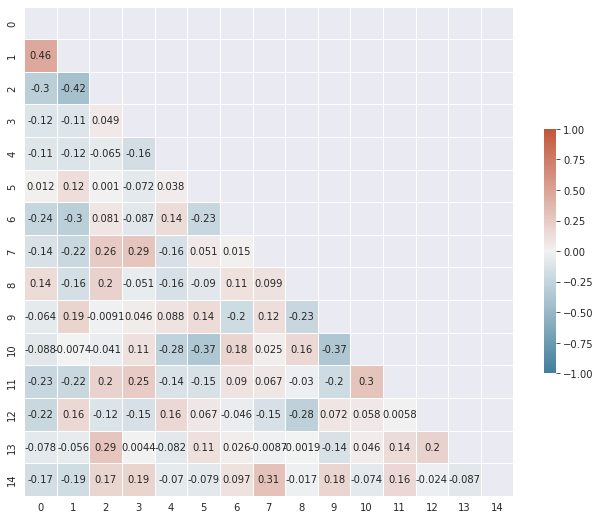

In [8]:
subject_1_harm_3 = a[0].reshape(correlation_matrices.shape[1], correlation_matrices.shape[2])
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(subject_1_harm_3, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(subject_1_harm_3, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Test with the real dataset subset

In [9]:
df = pd.read_excel('/home/kevrodz/Documents/Master/scripts/ADNI3_OASIS3_demographics_filenames.xlsx')
df.head()

,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri
0,6264,M,56.5,44.0,19,1.0,4.5,12,siemens,AD,ADNI3,dswau4D_003_S_6264_v164_.nii
1,6833,F,87.1,NaN,23,0.5,4.5,16,siemens,AD,ADNI3,dswau4D_003_S_6833_v164_.nii
2,6712,M,90.6,NaN,19,1.0,7.0,17,philips,AD,ADNI3,dswauADNI_019_S_6712_MR_Axial_fcMRI_0_angle__E...
3,6013,F,60.4,33.0,23,1.0,5.5,12,siemens,AD,ADNI3,dswau4D_022_S_6013_v164_.nii
4,6690,F,67.8,NaN,20,1.0,6.0,14,siemens,AD,ADNI3,dswau4D_082_S_6690_v164_.nii


In [10]:
# all mask by group, each mask has 15 nets (300ROI Seitzman + PMN)
masker_GICA_300ROI = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii',
                      '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_AD_ADNI3/nets_CN_AD_ADNI3.nii',
                      '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_OASIS3/nets_AD_OASIS3.nii',
                      '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_AD_OASIS3/nets_CN_AD_OASIS3.nii',
                      '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/MCI_ADNI3/nets_MCI_ADNI3.nii',
                      '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_MCI_ADNI3/nets_CN_MCI_ADNI3.nii']

In [11]:
# subjects
df_AD = df.loc[df['status'] == 'AD']
df_MCI = df.loc[df['status'] == 'MCI']
df_CN_AD = df.loc[df['status'] == 'CN_AD']
df_CN_MCI = df.loc[df['status'] == 'CN_MCI']

# Group Path
path_AD_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/'
path_AD_OASIS3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_OASIS3/'
path_MCI_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/MCI_V2_ADNI3/'
path_CN_AD_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/CN_AD_ADNI3/'
path_CN_AD_OASIS3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/CN_OASIS3/'
path_CN_MCI_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/CN_MCI_ADNI3/'

In [12]:
df_AD

,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri
0,6264,M,56.50,44.0,19,1.0,4.5,12,siemens,AD,ADNI3,dswau4D_003_S_6264_v164_.nii
1,6833,F,87.10,NaN,23,0.5,4.5,16,siemens,AD,ADNI3,dswau4D_003_S_6833_v164_.nii
2,6712,M,90.60,NaN,19,1.0,7.0,17,philips,AD,ADNI3,dswauADNI_019_S_6712_MR_Axial_fcMRI_0_angle__E...
3,6013,F,60.40,33.0,23,1.0,5.5,12,siemens,AD,ADNI3,dswau4D_022_S_6013_v164_.nii
4,6690,F,67.80,NaN,20,1.0,6.0,14,siemens,AD,ADNI3,dswau4D_082_S_6690_v164_.nii
...,...,...,...,...,...,...,...,...,...,...,...,...
59,OAS31086_MR_d0065,F,76.09,34.0,30,0.5,1.5,13,siemens,AD,OASIS3,dswausub-OAS31086_ses-d0065_task-rest_run-01_b...
60,OAS31129_MR_d0055,F,68.23,34.0,29,0.5,3.0,16,siemens,AD,OASIS3,dswausub-OAS31129_ses-d0055_task-rest_run-02_b...
61,OAS31139_MR_d0533,M,85.15,34.0,26,0.5,2.5,16,siemens,AD,OASIS3,dswausub-OAS31139_ses-d0533_task-rest_run-02_b...
62,OAS31140_MR_d0332,F,88.09,34.0,23,1.0,4.5,16,siemens,AD,OASIS3,dswausub-OAS31140_ses-d0332_task-rest_run-01_b...


In [13]:
paths_prefix = []
for row in df_AD.centro:
    if row == 'ADNI3':
        paths_prefix.append(path_AD_ADNI3)
    elif row == 'OASIS3':
        paths_prefix.append(path_AD_OASIS3)

df_AD['path'] = paths_prefix

df_AD

/tmp/ipykernel_18366/2090729601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AD['path'] = paths_prefix


,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri,path
0,6264,M,56.50,44.0,19,1.0,4.5,12,siemens,AD,ADNI3,dswau4D_003_S_6264_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
1,6833,F,87.10,NaN,23,0.5,4.5,16,siemens,AD,ADNI3,dswau4D_003_S_6833_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
2,6712,M,90.60,NaN,19,1.0,7.0,17,philips,AD,ADNI3,dswauADNI_019_S_6712_MR_Axial_fcMRI_0_angle__E...,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
3,6013,F,60.40,33.0,23,1.0,5.5,12,siemens,AD,ADNI3,dswau4D_022_S_6013_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
4,6690,F,67.80,NaN,20,1.0,6.0,14,siemens,AD,ADNI3,dswau4D_082_S_6690_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,OAS31086_MR_d0065,F,76.09,34.0,30,0.5,1.5,13,siemens,AD,OASIS3,dswausub-OAS31086_ses-d0065_task-rest_run-01_b...,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
60,OAS31129_MR_d0055,F,68.23,34.0,29,0.5,3.0,16,siemens,AD,OASIS3,dswausub-OAS31129_ses-d0055_task-rest_run-02_b...,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
61,OAS31139_MR_d0533,M,85.15,34.0,26,0.5,2.5,16,siemens,AD,OASIS3,dswausub-OAS31139_ses-d0533_task-rest_run-02_b...,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
62,OAS31140_MR_d0332,F,88.09,34.0,23,1.0,4.5,16,siemens,AD,OASIS3,dswausub-OAS31140_ses-d0332_task-rest_run-01_b...,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...


In [14]:
subjects_ts = df_AD.path + df_AD.rs_fmri
len(subjects_ts)

64

In [15]:
subjects_ts

0     /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
1     /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
2     /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
3     /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
4     /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
                            ...                        
59    /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
60    /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
61    /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
62    /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
63    /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
Length: 64, dtype: object

In [16]:
# ts shape (n_subjects), and in each subject shape (vols, rois)
ts, roi_img, labels, masker_type = signal_extract(subjects_ts, masker_GICA_300ROI[0], masker_type='Maps')


  1 region(s) detected from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.]

In [17]:
row=len(ts)
column=len(ts[0])
print(f'Rows:{row}, Column:{column}')
print("Shape of a list (ts):",len(ts))

Rows:64, Column:164
Shape of a list (ts): 64


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


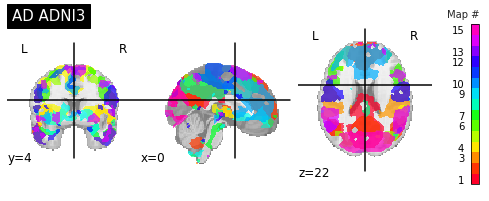

In [18]:
plotting.plot_prob_atlas(roi_img, title='AD ADNI3', colorbar=True)
plotting.show()

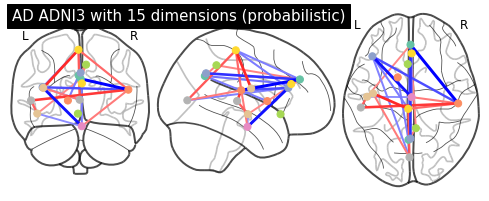

In [19]:
connectome_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices = connectome_measure.fit_transform(ts)

# Static correlation and mean
mean_correlation_matrix = connectome_measure.mean_
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=masker_GICA_300ROI[0])

plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='AD ADNI3 with {} dimensions (probabilistic)'.format(15))
plotting.show()

<AxesSubplot:>

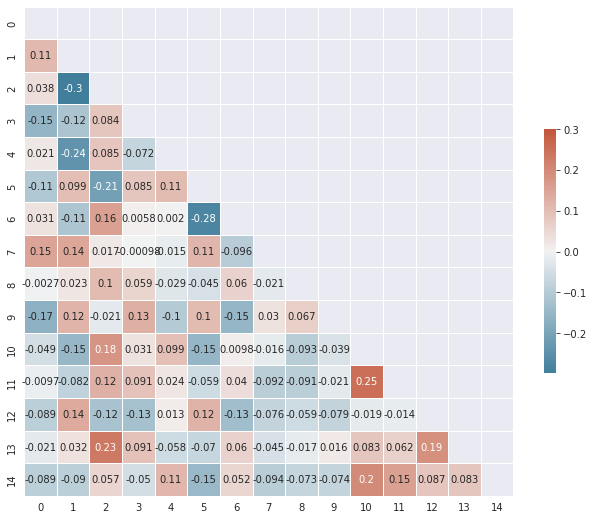

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.triu(np.ones_like(mean_correlation_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mean_correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [21]:
df_covars = df_AD[['SEXO', 'EDAD', 'Scanner', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'centro']]

from sklearn import preprocessing

df_covars[['le_SEXO', 'SITE']] = df_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
df_covars_num = df_covars.select_dtypes(include=np.number)
df_covars_num

/tmp/ipykernel_18366/1930358637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_18366/1930358637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)


,EDAD,MMSE,CDR_SOB,CDR_total,Escolaridad,le_SEXO,SITE
0,56.50,19,4.5,1.0,12,1,2
1,87.10,23,4.5,0.5,16,0,2
2,90.60,19,7.0,1.0,17,1,1
3,60.40,23,5.5,1.0,12,0,2
4,67.80,20,6.0,1.0,14,0,2
...,...,...,...,...,...,...,...
59,76.09,30,1.5,0.5,13,0,2
60,68.23,29,3.0,0.5,16,0,2
61,85.15,26,2.5,0.5,16,1,2
62,88.09,23,4.5,1.0,16,0,2


In [22]:
correlation_matrices[0]

array([[ 1.        ,  0.1003423 , -0.28217006, -0.19373874,  0.25814295,
         0.09310248,  0.01718695, -0.16018909, -0.06077   , -0.3333016 ,
         0.18990229, -0.24529932, -0.04244712, -0.20266563,  0.09166029],
       [ 0.1003423 ,  1.        , -0.13823962, -0.00175901,  0.05370326,
         0.07559028,  0.07700152, -0.04589603, -0.18840474,  0.25748938,
         0.19297402, -0.0384394 ,  0.13062456, -0.01930798,  0.15950297],
       [-0.28217006, -0.13823962,  1.        ,  0.19866396, -0.16544594,
        -0.20088391, -0.19098221,  0.3351439 ,  0.23697028,  0.03311756,
         0.13297543,  0.29808274,  0.06388599,  0.2796323 , -0.28361824],
       [-0.19373874, -0.00175901,  0.19866396,  1.        , -0.20114863,
         0.13492022, -0.10255211, -0.12428915, -0.15131329,  0.22282833,
        -0.22115152, -0.11458439, -0.10498473,  0.19723673, -0.16588467],
       [ 0.25814295,  0.05370326, -0.16544594, -0.20114863,  1.        ,
         0.30408722, -0.07491934, -0.11457933, 

In [25]:
my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=correlation_matrices, cov=df_covars_num, v=0)
correlation_matrices_harmonized[0]

array([[ 1.        ,  0.08816509, -0.2619893 , -0.19883799,  0.25212791,
         0.07978962,  0.02347856, -0.15283613, -0.06622434, -0.33793699,
         0.18313945, -0.24709843, -0.03642747, -0.18688734,  0.09447865],
       [ 0.08816509,  1.        , -0.13210757, -0.01549278,  0.04879843,
         0.08666396,  0.06432701, -0.04386265, -0.19730944,  0.24614277,
         0.20048698, -0.03560648,  0.12892061, -0.01632228,  0.15039375],
       [-0.2619893 , -0.13210757,  1.        ,  0.20293983, -0.16172442,
        -0.19783636, -0.20316051,  0.32678594,  0.22958174,  0.03550498,
         0.11853329,  0.2849892 ,  0.06377898,  0.27756599, -0.27944377],
       [-0.19883799, -0.01549278,  0.20293983,  1.        , -0.2024823 ,
         0.1196614 , -0.09762932, -0.12638069, -0.15354756,  0.21922774,
        -0.22673843, -0.11430382, -0.11008462,  0.19864032, -0.16970009],
       [ 0.25212791,  0.04879843, -0.16172442, -0.2024823 ,  1.        ,
         0.28626202, -0.06815874, -0.10657865, 

In [26]:
df_covars2 = df_AD[['SEXO', 'EDAD', 'Scanner', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'centro']]
df_covars2 = pd.get_dummies(df_covars2, columns=['centro', 'SEXO'])
df_covars2.rename(columns={'Scanner': 'SITE'}, inplace=True)
df_covars2

,EDAD,SITE,MMSE,CDR_SOB,CDR_total,Escolaridad,centro_ADNI3,centro_OASIS3,SEXO_F,SEXO_M
0,56.50,siemens,19,4.5,1.0,12,1,0,0,1
1,87.10,siemens,23,4.5,0.5,16,1,0,1,0
2,90.60,philips,19,7.0,1.0,17,1,0,0,1
3,60.40,siemens,23,5.5,1.0,12,1,0,1,0
4,67.80,siemens,20,6.0,1.0,14,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
59,76.09,siemens,30,1.5,0.5,13,0,1,1,0
60,68.23,siemens,29,3.0,0.5,16,0,1,1,0
61,85.15,siemens,26,2.5,0.5,16,0,1,0,1
62,88.09,siemens,23,4.5,1.0,16,0,1,1,0


In [27]:
correlation_matrices_harmonized2 = corr_matrix_harmonization(corr=correlation_matrices, cov=df_covars2[['SITE', 'EDAD', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'SEXO_F']], v=0, smooth_terms=['EDAD'])
correlation_matrices_harmonized2[0]

{'design': array([[ 0.        ,  0.        ,  1.        , 56.5       , 19.        ,
          4.5       ,  1.        , 12.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        , 87.09999847, 23.        ,
          4.5       ,  0.5       , 16.        ,  1.        ],
        [ 0.        ,  1.        ,  0.        , 90.59999847, 19.        ,
          7.        ,  1.        , 17.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        , 60.40000153, 23.        ,
          5.5       ,  1.        , 12.        ,  1.        ],
        [ 0.        ,  0.        ,  1.        , 67.80000305, 20.        ,
          6.        ,  1.        , 14.        ,  1.        ],
        [ 1.        ,  0.        ,  0.        , 80.90000153, 21.        ,
          6.5       ,  1.        , 14.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        , 79.80000305, 18.        ,
          6.        ,  1.        , 14.        ,  0.        ],
        [ 1.        ,  0.        ,  0.

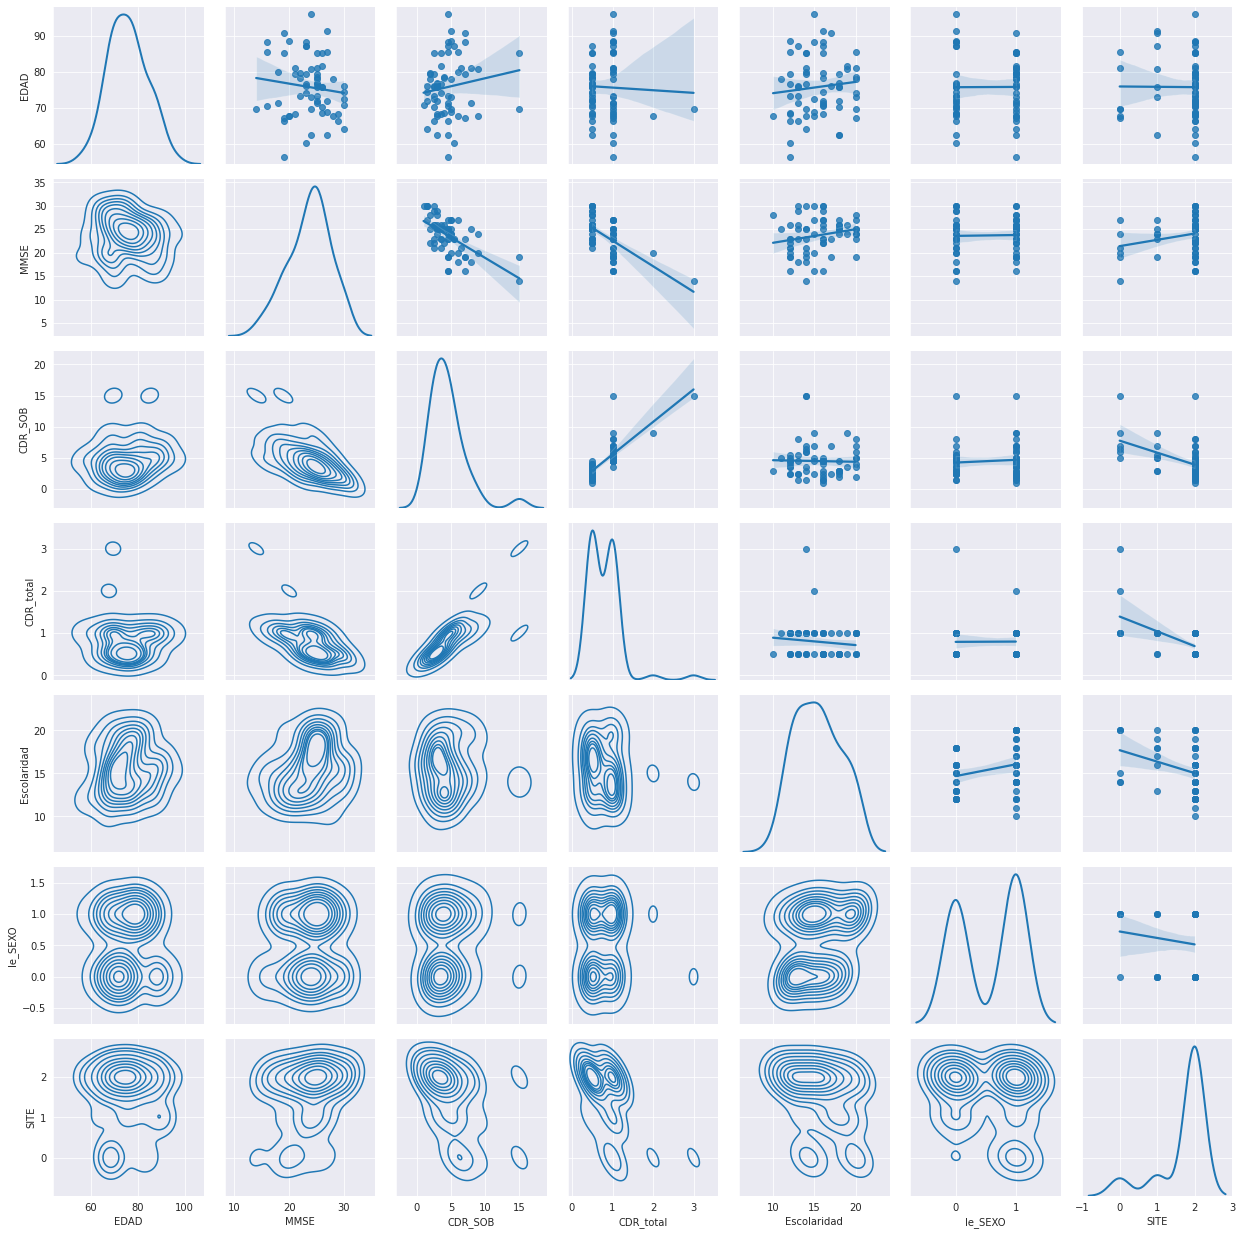

In [28]:
g = sns.PairGrid(df_covars_num, diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_upper(sns.regplot)
g.map_diag(sns.kdeplot, lw=2)

## Cuales covariables usar?

1: (df_covars_num) se asume relación lineal en tdas las covariables
2: (df_covars2) no se tiene relación lineal en EDAD

Los resultados son similares y las gráficas de reg lineal muestran linealidad con bajo ajuste, entonces se decide dejar opción 1, asumir que toas las covariables son lineales.

In [29]:
paths_prefix = []
for row in df_MCI.centro:
    if row == 'ADNI3':
        paths_prefix.append(path_MCI_ADNI3)
    elif row == 'OASIS3':
        paths_prefix.append(path_MCI_OASIS3)

df_MCI['path'] = paths_prefix

df_MCI

/tmp/ipykernel_18366/3256807191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MCI['path'] = paths_prefix


,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri,path
149,6414,F,70.2,34.0,28,0.0,0.0,16,philips,MCI,ADNI3,dswauADNI_018_S_6414_S2019_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
150,6635,F,56.6,NaN,28,0.5,1.0,18,philips,MCI,ADNI3,dswauADNI_019_S_6635_S2018_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
151,4417,M,82.1,33.0,28,0.5,0.5,16,philips,MCI,ADNI3,dswauADNI_130_S_4417_S2019_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
152,6804,M,69.2,NaN,25,0.5,1.0,16,siemens,MCI,ADNI3,dswauADNI_032_S_6804_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
153,377,M,90.3,34.0,27,0.5,1.0,16,siemens,MCI,ADNI3,dswauADNI_037_S_0377_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
154,6083,M,72.2,33.0,27,0.5,0.5,12,siemens,MCI,ADNI3,dswauADNI_037_S_6083_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
155,6426,F,80.8,33.0,26,0.5,1.0,14,siemens,MCI,ADNI3,dswauADNI_168_S_6426_S2019_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
156,6467,F,71.3,33.0,27,0.5,1.0,13,siemens,MCI,ADNI3,dswauADNI_168_S_6467_S2018_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
157,6873,M,72.2,NaN,27,0.5,1.5,14,siemens,MCI,ADNI3,dswauADNI_168_S_6873_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...
158,6731,F,68.2,NaN,28,0.5,2.5,20,siemens,MCI,ADNI3,dswauADNI_041_S_6731_S2020_4D_v164_.nii,/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/...


In [30]:
subjects_ts = df_MCI.path + df_MCI.rs_fmri
len(subjects_ts)

58

In [31]:
# ts shape (n_subjects), and in each subject shape (vols, rois)
ts, roi_img, labels, masker_type = signal_extract(subjects_ts, masker_GICA_300ROI[4], masker_type='Maps')

  1 region(s) detected from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/MCI_ADNI3/nets_MCI_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/MCI_ADNI3/nets_MCI_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/MCI_ADNI3/nets_MCI_ADNI3.nii


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/MCI_ADNI3/nets_MCI_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/MCI_V2_ADNI3/dswauADNI_130_S_4417_S2019_4D_v164_.nii', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7f

In [32]:
row=len(ts)
column=len(ts[0])
print(f'Rows:{row}, Column:{column}')
print("Shape of a list (ts):",len(ts))

Rows:58, Column:164
Shape of a list (ts): 58


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


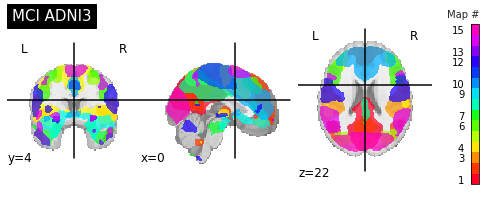

In [33]:
plotting.plot_prob_atlas(roi_img, title='MCI ADNI3', colorbar=True)
plotting.show()

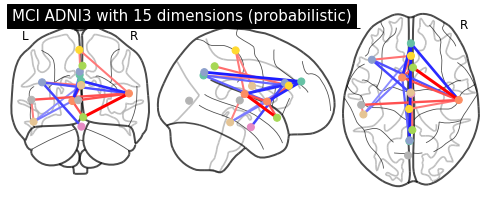

In [34]:
connectome_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices = connectome_measure.fit_transform(ts)

# Static correlation and mean
mean_correlation_matrix = connectome_measure.mean_
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=masker_GICA_300ROI[4])

plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='MCI ADNI3 with {} dimensions (probabilistic)'.format(15))
plotting.show()

<AxesSubplot:>

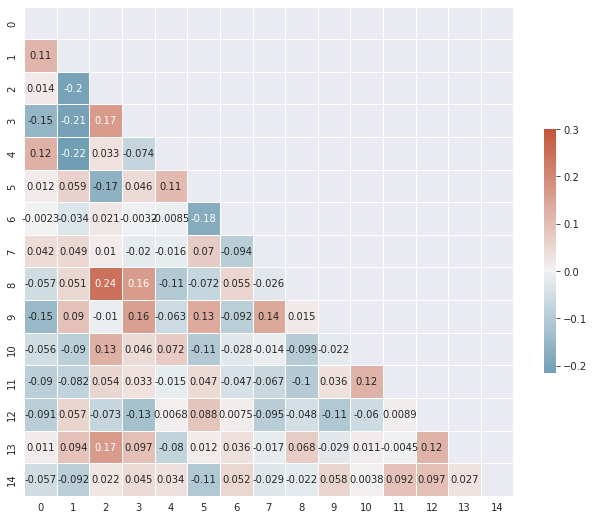

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.triu(np.ones_like(mean_correlation_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mean_correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [36]:
df_covars = df_MCI[['SEXO', 'EDAD', 'Scanner', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'centro']]

from sklearn import preprocessing

df_covars[['le_SEXO', 'SITE']] = df_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
df_covars_num = df_covars.select_dtypes(include=np.number)
df_covars_num

/tmp/ipykernel_18366/1902799866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_18366/1902799866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)


,EDAD,MMSE,CDR_SOB,CDR_total,Escolaridad,le_SEXO,SITE
149,70.2,28,0.0,0.0,16,0,1
150,56.6,28,1.0,0.5,18,0,1
151,82.1,28,0.5,0.5,16,1,1
152,69.2,25,1.0,0.5,16,1,2
153,90.3,27,1.0,0.5,16,1,2
154,72.2,27,0.5,0.5,12,1,2
155,80.8,26,1.0,0.5,14,0,2
156,71.3,27,1.0,0.5,13,0,2
157,72.2,27,1.5,0.5,14,1,2
158,68.2,28,2.5,0.5,20,0,2


In [37]:
correlation_matrices[0]

array([[ 1.        ,  0.60834974, -0.2831451 , -0.32471398, -0.2444888 ,
        -0.05308483,  0.23548661,  0.38616014, -0.13693243, -0.04732905,
        -0.261696  , -0.09519907,  0.22301134, -0.03496016, -0.17405796],
       [ 0.60834974,  1.        , -0.41932556, -0.37774536, -0.42397785,
         0.08711538,  0.07769605,  0.4111    , -0.00465504,  0.07277142,
        -0.14978409, -0.15088743,  0.13609998, -0.02597821, -0.358903  ],
       [-0.2831451 , -0.41932556,  1.        ,  0.47453368,  0.48766968,
        -0.20568916, -0.17493951, -0.27275023,  0.17465602,  0.0028104 ,
         0.49584675,  0.33735704,  0.05811575,  0.31060484,  0.4489778 ],
       [-0.32471398, -0.37774536,  0.47453368,  1.        ,  0.2654797 ,
        -0.06912196, -0.0631284 , -0.12586518,  0.14794643,  0.15493152,
         0.36374015,  0.33270055, -0.2277384 ,  0.21728764,  0.18050785],
       [-0.2444888 , -0.42397785,  0.48766968,  0.2654797 ,  1.        ,
         0.22979029, -0.21588346, -0.30982178, 

In [38]:
my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=correlation_matrices, cov=df_covars_num, v=0)
correlation_matrices_harmonized[0]

array([[ 1.        ,  0.59636056, -0.30275532, -0.34065565, -0.16721982,
        -0.02443369,  0.24293828,  0.36567272, -0.17381854, -0.07572325,
        -0.21014083, -0.08874312,  0.22921892, -0.03744016, -0.20049087],
       [ 0.59636056,  1.        , -0.38829131, -0.38661571, -0.36134505,
         0.07858409,  0.01222187,  0.41630603,  0.00173785,  0.0543471 ,
        -0.08168515, -0.11896279,  0.15345547,  0.02252552, -0.2966088 ],
       [-0.30275532, -0.38829131,  1.        ,  0.43039103,  0.47188304,
        -0.18616724, -0.17951666, -0.29205915,  0.15559597,  0.02758778,
         0.47726923,  0.38449893,  0.05344514,  0.26460357,  0.43557231],
       [-0.34065565, -0.38661571,  0.43039103,  1.        ,  0.25312011,
        -0.04011303, -0.03925432, -0.09295943,  0.1168877 ,  0.17704186,
         0.29457433,  0.29942648, -0.22621045,  0.15606831,  0.18260776],
       [-0.16721982, -0.36134505,  0.47188304,  0.25312011,  1.        ,
         0.2201225 , -0.17224078, -0.38305336, 

/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/statsmodels/r

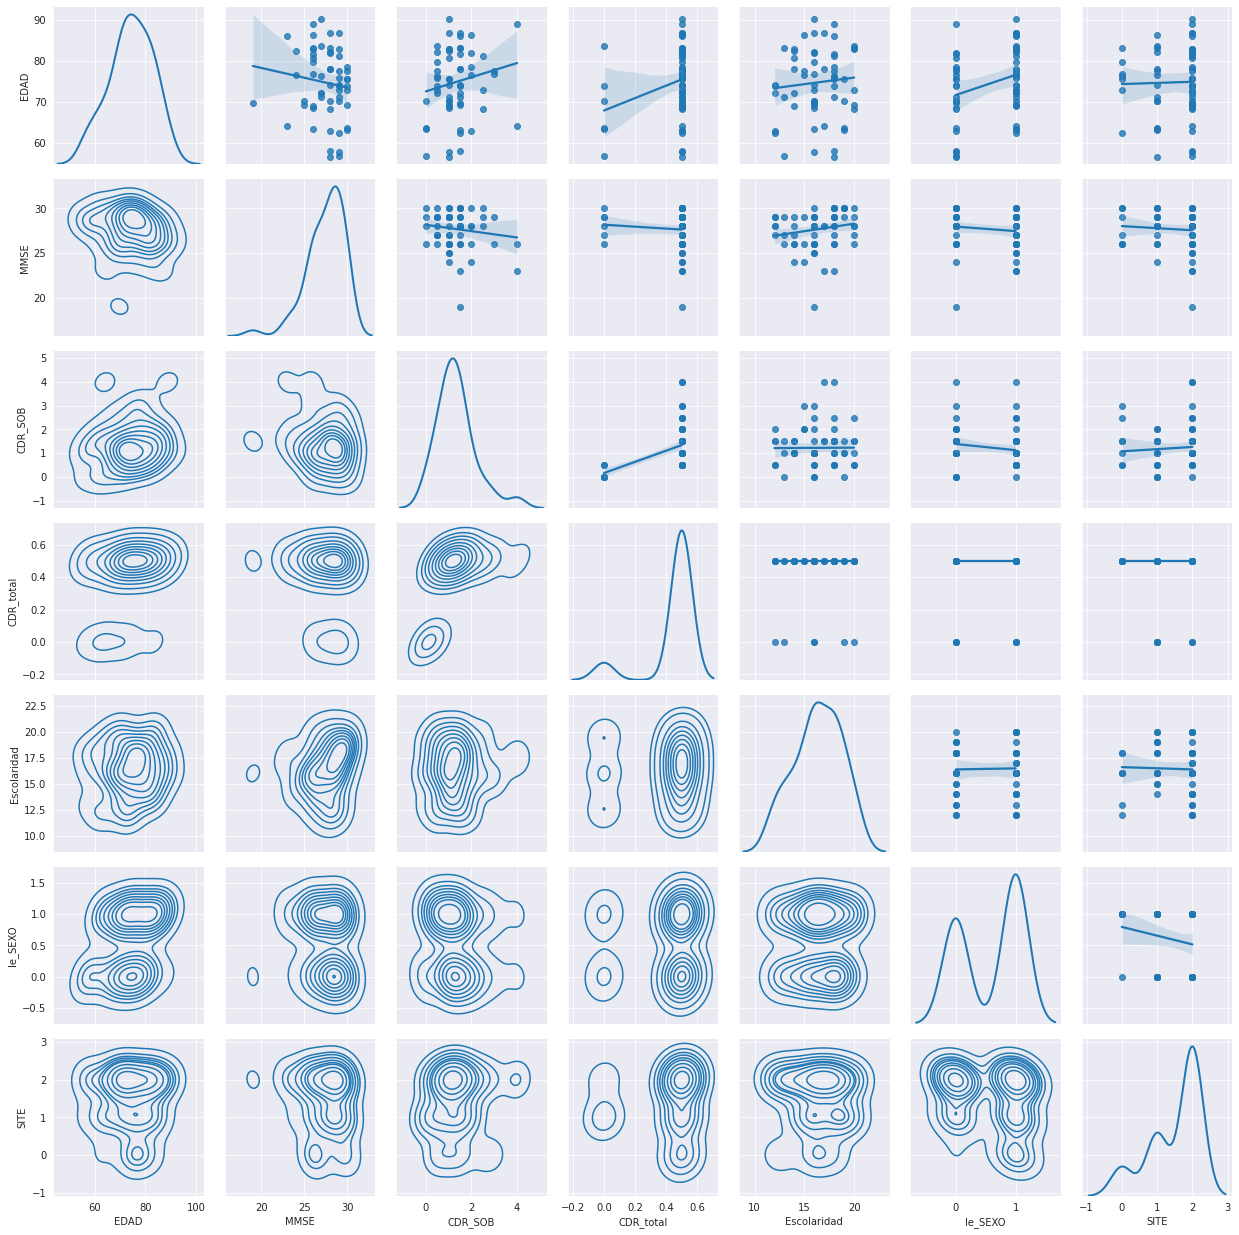

In [39]:
g = sns.PairGrid(df_covars_num, diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_upper(sns.regplot, robust=True)
g.map_diag(sns.kdeplot, lw=2)

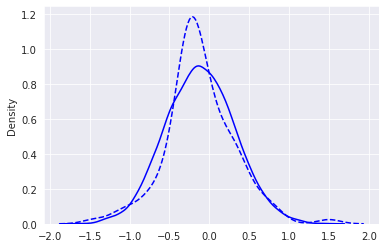

In [41]:
site_01 = stats.norm.rvs(size=10000, loc=my_model['gamma_bar'][0], scale=np.sqrt(my_model['t2'][0]))
sns.kdeplot(site_01, color='blue', label='Site-1-prior')
sns.kdeplot(my_model['gamma_hat'][0, :], color='blue', label='Site-1-observed', linestyle='--')
plt.show()

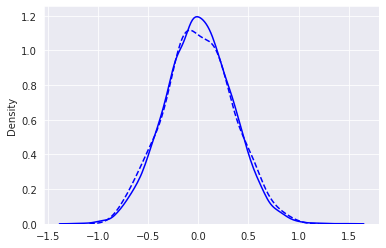

In [42]:
site_02 = stats.norm.rvs(size=10000, loc=my_model['gamma_bar'][1], scale=np.sqrt(my_model['t2'][1]))
sns.kdeplot(site_02, color='blue', label='Site-2-prior')
sns.kdeplot(my_model['gamma_hat'][1, :], color='blue', label='Site-2-observed', linestyle='--')
plt.show()

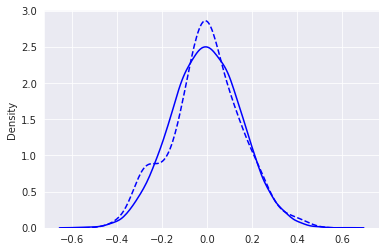

In [43]:
site_03 = stats.norm.rvs(size=10000, loc=my_model['gamma_bar'][2], scale=np.sqrt(my_model['t2'][2]))
sns.kdeplot(site_03, color='blue', label='Site-3-prior')
sns.kdeplot(my_model['gamma_hat'][2, :], color='blue', label='Site-3-observed', linestyle='--')
plt.show()